In [2]:
import torch
import torch.nn as nn
import numpy as np


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Code from scratch hàm transposed convolution

In [3]:
def transposed_convolutional(x, k, stride = (1, 1), padding = (0, 0)):
    h, w = k.shape
    output_h = (x.shape[0] - 1) * stride[0] + k.shape[0]
    output_w = (x.shape[1] - 1) * stride[1] + k.shape[1]
    y = np.zeros((output_h, output_w))
    for i in range(0, x.shape[0]):
        for j in range(0, x.shape[1]):
            y[i * stride[0]: i * stride[0] + k.shape[0], j * stride[1] : j * stride[1] + k.shape[1]] += x[i, j] * k

    if padding[0] > 0:
        for i in range(padding[0]):
            y = np.delete(y, (0), axis=0)
            y = np.delete(y, (-1), axis=0)
    if padding[1] > 0:
        for i in range(padding[1]):
            y = np.delete(y, (0), axis=1)
            y = np.delete(y, (-1), axis=1)
    return y

In [4]:
Input = np.array([[ 1.,  2.],
          [ 3.,  4.]])
#Kernel
Kernel = np.array([[ 3.,  0.,  2.],
          [ 0.,  0.,  0.],
          [ 2.,  0., 12.]])


transposed_convolutional(Input, Kernel, (3, 3), padding = (1, 1))

array([[ 0.,  0.,  0.,  0.],
       [ 0., 12.,  4.,  0.],
       [ 0.,  6., 12.,  0.],
       [ 0.,  0.,  0.,  0.]])

In [5]:
Input = torch.tensor([[ 1.,  2.],
          [ 3.,  4.]])
#Kernel
Kernel = torch.tensor([[ 3.,  0.,  2.],
          [ 0.,  0.,  0.],
          [ 2.,  0., 12.]])

# Redefine the shape in 4 dimension
Input = Input.reshape(1, 1, 2, 2)
Kernel = Kernel.reshape(1, 1, 3, 3)

# Transpose convolution Layer
Transpose = nn.ConvTranspose2d(in_channels =1,
                               out_channels =1,
                               kernel_size=2,
                               stride = (3, 3),
                               padding = (1, 1),
                               bias=False)


Transpose.weight.data = Kernel
# Output value
Transpose(Input)

tensor([[[[ 0.,  0.,  0.,  0.],
          [ 0., 12.,  4.,  0.],
          [ 0.,  6., 12.,  0.],
          [ 0.,  0.,  0.,  0.]]]], grad_fn=<ConvolutionBackward0>)

# Bài 2: Cho dataset cifar-10 
Cho noise cho dataset được sample từ normal distribution (mean = 0, variance = 0.1)


In [6]:
from torchvision import transforms
def add_noise(inputs):
    noise = 0.12 * torch.randn_like(inputs)
    return inputs + noise

transform=transforms.Compose([
    transforms.ToTensor()
])



In [7]:
from torchvision import datasets
from torch.utils.data import DataLoader

cifar10 = datasets.CIFAR10(".", train=True, download=True, transform = transform)
loader = DataLoader(cifar10, batch_size = 32, shuffle = False)


100%|██████████| 170498071/170498071 [00:01<00:00, 104411394.54it/s]


Extracting ./cifar-10-python.tar.gz to .


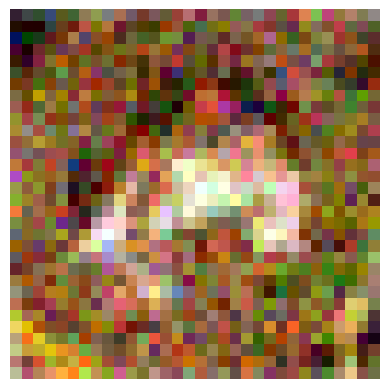

In [8]:
import matplotlib.pyplot as plt

image = add_noise(cifar10[0][0])
plt.imshow(image.permute(1, 2, 0))
plt.axis("off")
plt.show()

Dùng cấu trúc autoencoder để denoise lại bức ảnh về như ban đầu

In [9]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),
            nn.ReLU(),

            nn.Conv2d(12, 24, 4, stride=2, padding=1),
            nn.ReLU(),

            nn.Conv2d(24, 48, 4, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded



In [10]:

model = AutoEncoder().to(device)

loss_function = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(),
                             lr = 0.01)

In [11]:
epochs = 10
for epoch in range(1, epochs+1):
    # monitor training loss
    train_loss = 0.0
    for data in loader:
        images, _ = data
        noisy_imgs = images + 0.12 * torch.randn(*images.shape)
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        optimizer.zero_grad()
        outputs = model(noisy_imgs.cuda())
        loss = loss_function(outputs, images.cuda())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
    train_loss = train_loss/len(loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch,
        train_loss
        ))

Epoch: 1 	Training Loss: 0.331325
Epoch: 2 	Training Loss: 0.183947
Epoch: 3 	Training Loss: 0.155535
Epoch: 4 	Training Loss: 0.149657
Epoch: 5 	Training Loss: 0.144360
Epoch: 6 	Training Loss: 0.144828
Epoch: 7 	Training Loss: 0.141510
Epoch: 8 	Training Loss: 0.146621
Epoch: 9 	Training Loss: 0.140981
Epoch: 10 	Training Loss: 0.141124


In [12]:
test_data = datasets.CIFAR10(root='data', train=False,
                                  download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=20, num_workers = 0)

dataiter = iter(test_loader)
image, label = next(dataiter)

100%|██████████| 170498071/170498071 [00:02<00:00, 81013719.62it/s]


Extracting data/cifar-10-python.tar.gz to data


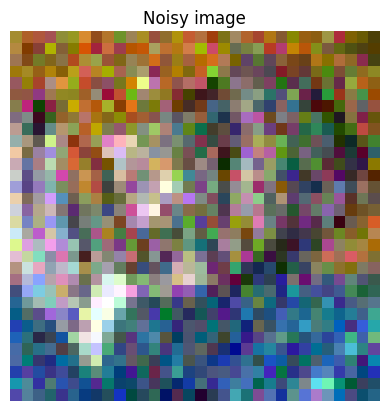

In [40]:
noisy_imgs = image + 0.12 * torch.randn(*image.shape)
noisy_imgs = noisy_imgs[0]
plt.imshow(noisy_imgs.permute(1, 2, 0))
plt.title("Noisy image")
plt.axis("off")
plt.show()

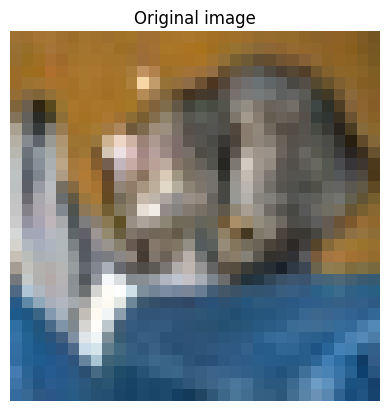

In [38]:

plt.imshow(image[0].permute(1, 2, 0))
plt.title("Original image")
plt.axis("off")
plt.show()

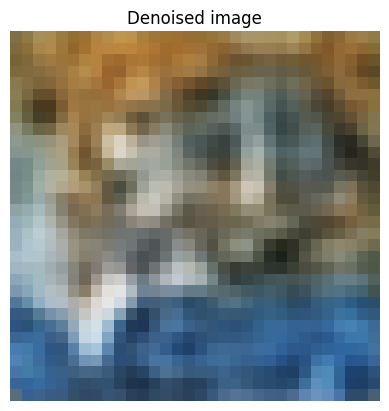

In [39]:
plt.imshow(model(noisy_imgs.to(device)).cpu().detach().permute(1, 2, 0))
plt.title("Denoised image")
plt.axis("off")
plt.show()

# 3. Cho dataset cifar-10 
Giảm chiều dữ liệu về dạng 2d của 1 ảnh bất kỳ bằng 2 phương pháp: PCA và convolution AE.

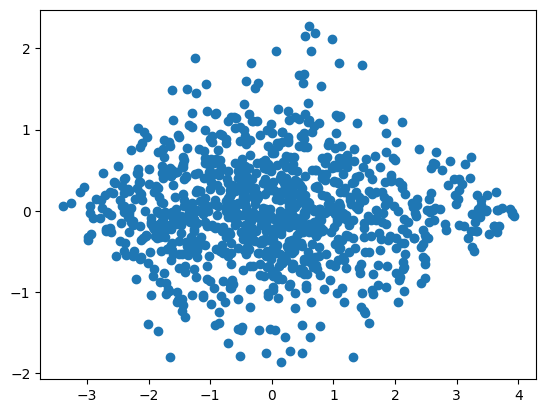

In [48]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

images_flat = image.reshape(1024, -1).numpy()
dimesion_reduced = pca.fit_transform(images_flat)

plt.scatter(dimesion_reduced[:, 0], dimesion_reduced[:, 1])

In [17]:

model = AutoEncoder().to(device)

loss_function = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(),
                             lr = 0.01)

In [18]:
epochs = 10
for epoch in range(1, epochs+1):
    # monitor training loss
    train_loss = 0.0
    for data in loader:
        images, _ = data
        optimizer.zero_grad()
        outputs = model(images.cuda())
        loss = loss_function(outputs, images.cuda())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
    train_loss = train_loss/len(loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch,
        train_loss
        ))

Epoch: 1 	Training Loss: 0.297498
Epoch: 2 	Training Loss: 0.147405
Epoch: 3 	Training Loss: 0.133311
Epoch: 4 	Training Loss: 0.126640
Epoch: 5 	Training Loss: 0.123933
Epoch: 6 	Training Loss: 0.121226
Epoch: 7 	Training Loss: 0.120018
Epoch: 8 	Training Loss: 0.116412
Epoch: 9 	Training Loss: 0.113443
Epoch: 10 	Training Loss: 0.112258


In [26]:
with torch.no_grad():
    encoded = model.encoder(image.cuda())
    decoded = model.decoder(encoded)
    mse = loss_function(decoded, image.cuda()).item()
    enc = encoded.cpu().detach().numpy()
    dec = decoded.cpu().detach().numpy()

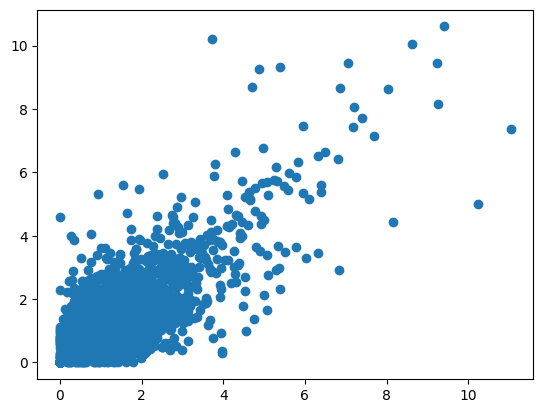

In [31]:
encoded = enc.reshape(-1, 2)
plt.scatter(encoded[:, 0], encoded[:, 1])

So sánh PCA và Autoencoder:
* PCA hoạt động tốt trên không gian tuyến tính còn Autoencoder có thể hoạt động trên các hàm phi tuyến tính phức tạp.
* các đặc trưng của PCA không có nhiều quan hệ còn các thuộc tính của Autoencoder các quan hệ với nhau để khôi phục thông tin gốc.
* PCA tính toán nhanh hơn.
* Autoencoder dễ overfitting do nhiều parameters